---
# Create LGM lower boundary conditions for CAM7
- Author: Jiang Zhu (jiangzhu@ucar.edu)
- References
  - [PMIP4 LGM protocols: Section 4.1](https://gmd.copernicus.org/articles/10/4035/2017/)
    - CO2 = 190 ppm
    - CH4 = 375 ppm
    - N2O = 200 ppv
    - CFCs = 0
---

In [1]:
import subprocess
import datetime

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf

import warnings
warnings.filterwarnings('ignore')

---
# Input

In [2]:
lbc_file_pre = '/glade/campaign/cesm/cesmdata/inputdata/atm/waccm/lb/CMIP7/LBC_17500116-20221216_CMIP7_0p5degLat_c250326.nc'
print(lbc_file_pre)

ds_lbc_pre = xr.open_dataset(lbc_file_pre).sel(time="1850")
ds_lbc_pre

/glade/campaign/cesm/cesmdata/inputdata/atm/waccm/lb/CMIP7/LBC_17500116-20221216_CMIP7_0p5degLat_c250326.nc


<xarray.Dataset> Size: 953kB
Dimensions:         (time: 12, lat: 360, lon: 288)
Coordinates:
  * time            (time) datetime64[ns] 96B 1850-01-16T12:00:00 ... 1850-12...
  * lat             (lat) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * lon             (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
Data variables: (12/56)
    date            (time) int32 48B ...
    C2F6_LBC        (time, lat) float32 17kB ...
    C3F8_LBC        (time, lat) float32 17kB ...
    C4F10_LBC       (time, lat) float32 17kB ...
    C5F12_LBC       (time, lat) float32 17kB ...
    C6F14_LBC       (time, lat) float32 17kB ...
    ...              ...
    TOT_CLOY        (time, lat) float32 17kB ...
    H2_LBC          (time, lat) float32 17kB ...
    TOT_BROY        (time, lat) float32 17kB ...
    TOT_EECL        (time, lat) float32 17kB ...
    H1202_LBC       (time, lat) float32 17kB ...
    TOT_FOY         (time, lat) float32 17kB ...
Attributes:
    data_title:     Time dependent mole fraction surface boundary conditions
    data_source:    File created by Jun Zhang
    creation_date:  2025-03-26
    data_script:    Python code (contact Jun Zhang, jzhan166@ucar.edu)
    data_summary:   All lower boundary condition fields are taken from the CM...

---
# Output

In [3]:
today = datetime.date.today().strftime("%y%m%d")
print(today)

work_dir = '/glade/work/jiangzhu/data/inputdata/cesm3_21ka'
lbc_fname_lgm = f"LBC_1850_pmip7_21ka_0p5degLat_c{today}.nc"

lbc_file_lgm = f"{work_dir}/{lbc_fname_lgm}"
print(lbc_file_lgm)

260119
/glade/work/jiangzhu/data/inputdata/cesm3_21ka/LBC_1850_pmip7_21ka_0p5degLat_c260119.nc


---
# Create the LGM LBC file

In [4]:
ds_lbc_lgm = ds_lbc_pre.copy(deep=True)

coslat = np.cos(np.deg2rad(ds_lbc_lgm.lat))
mon_len = ds_lbc_lgm.time.dt.days_in_month

# Update GHGs and keep the preindustrial seasonal and latitudinal variation
for vname, new_val in zip(['CO2_LBC', 'CH4_LBC', 'N2O_LBC'],
                          (190.0 / 1e6, 375.0 / 1e9, 200.0 / 1e9)):

    ds_lbc_lgm[vname].data = ds_lbc_lgm[vname] - ds_lbc_lgm[vname].weighted(
        coslat * mon_len).mean(('time', 'lat')) + new_val

# Remove CFCs
for vname in ds_lbc_lgm.keys():
    if vname[:3] == 'CFC':
        print(f"Set {vname} to zero everywhere")
        ds_lbc_lgm[vname].data = ds_lbc_lgm[vname] * 0.0

Set CFCL3_LBC to zero everywhere
Set CFC11eq_LBC to zero everywhere
Set CFC113_LBC to zero everywhere
Set CFC114_LBC to zero everywhere
Set CFC115_LBC to zero everywhere
Set CFC12EQ_LBC to zero everywhere


---
# Save output

In [5]:
ds_lbc_lgm.attrs['Title']  = 'PMIP7 21ka LBC boundary conditions'
ds_lbc_lgm.attrs['Author'] = 'Jiang Zhu (jiangzhu@ucar.edu)'
ds_lbc_lgm.attrs['Source_file'] = f'{lbc_file_pre}'
ds_lbc_lgm.attrs['Script'] = 'create_cam7_LBC.ipynb'
ds_lbc_lgm.attrs['More_info'] = 'https://github.com/NCAR/paleowg-recipes/cesm3_lgm'

ds_lbc_lgm.to_netcdf(lbc_file_lgm, format="NETCDF3_64BIT")

---
# Plot to examine results

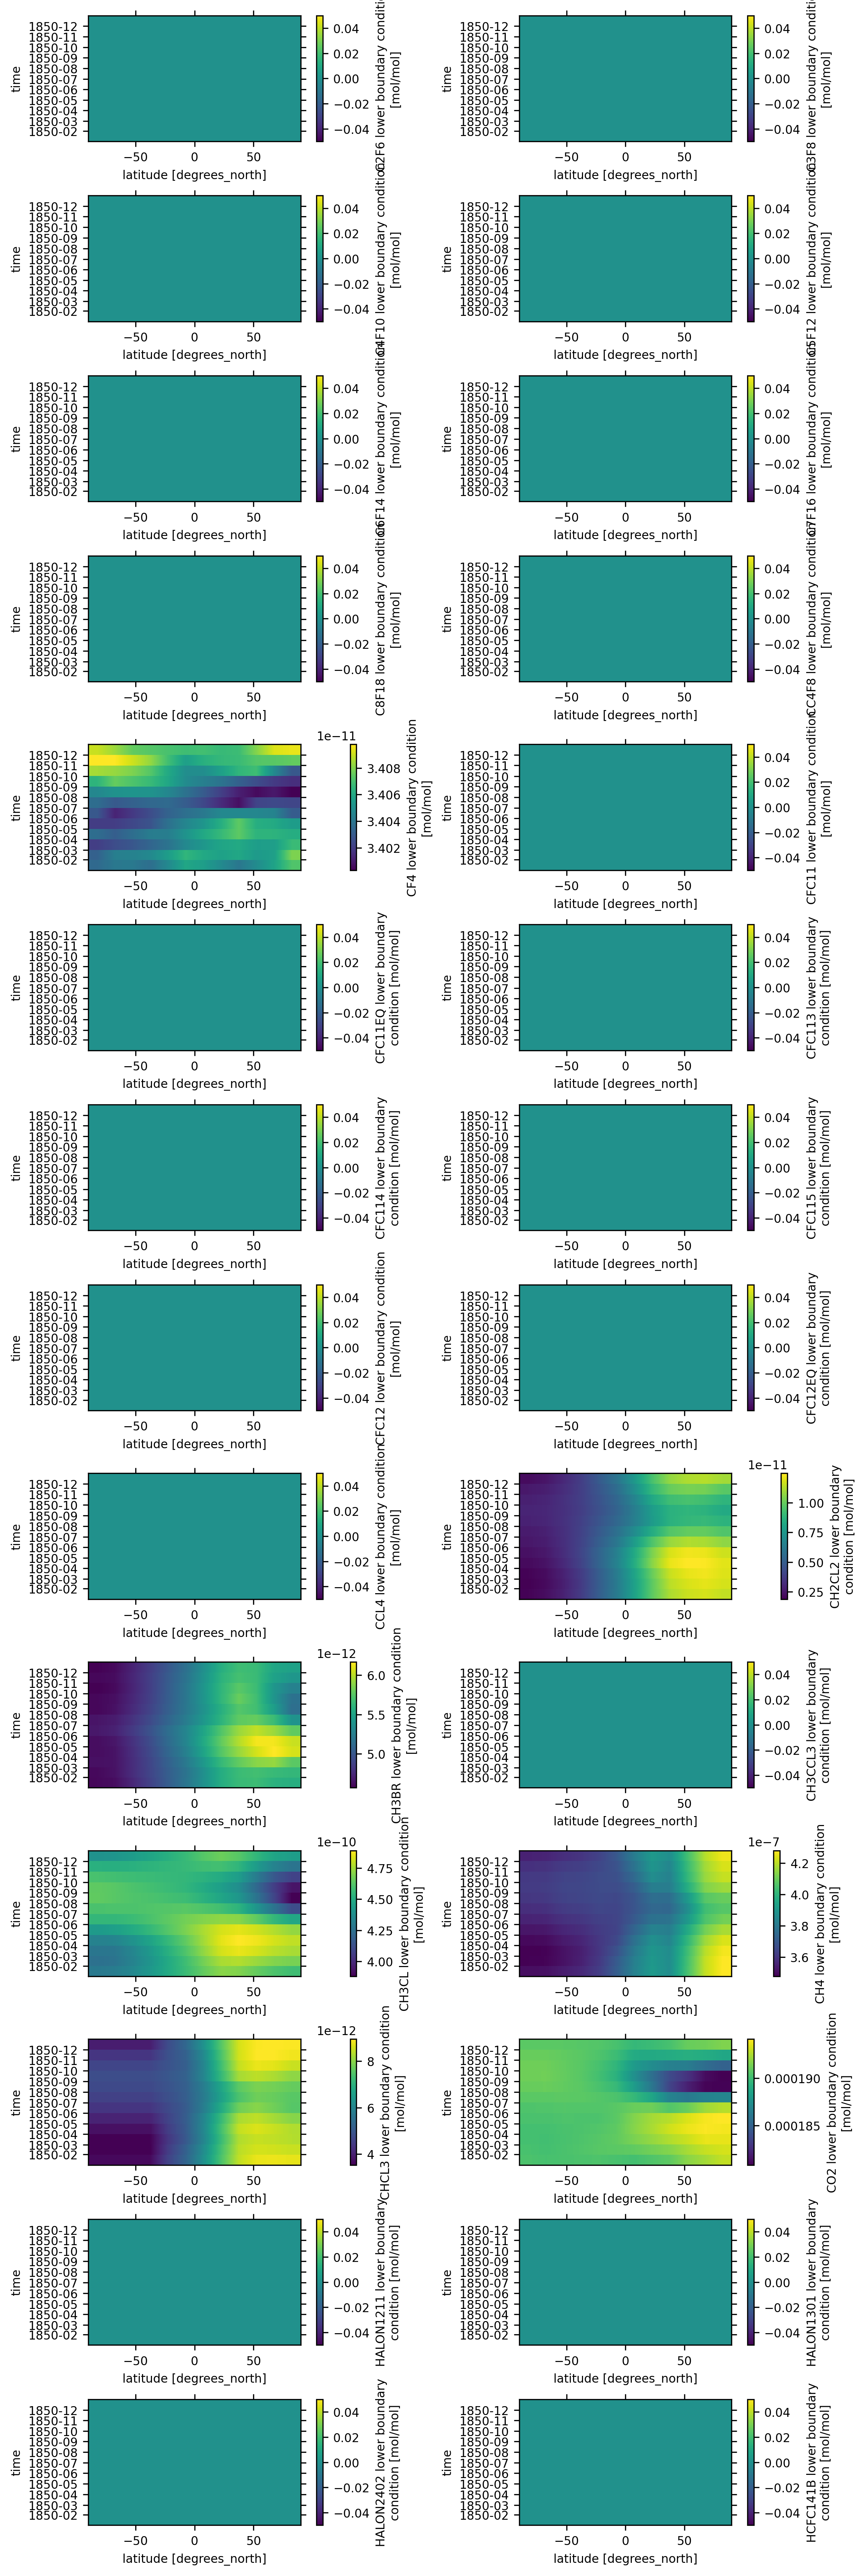

In [6]:
fig, axes = plt.subplots(14, 2, figsize=(8, 24),
                         sharex=False, sharey=False,
                         dpi=300,
                         constrained_layout=True)

var_list = ds_lbc_lgm.keys()
var_list = [item for item in var_list if item[:4] != 'time']
var_list = [item for item in var_list if item[:4] != 'date']

for ax, vname in zip(axes.ravel(), var_list):
        ds_lbc_lgm[vname].plot(ax=ax)